# Upscaling Pore-scale effects to continuum scale

In [2]:
import numpy as np
import torch
import matplotlib.pyplot as plt

from pytorch_lightning import Trainer

from src.lightning_model import DPmodel, load_data

/Users/jesantos/opt/anaconda3/envs/daily/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
fracture    = load_data('src/example_fracture.mat')
aperture    = fracture['fracture_1']['aperture_field']
pressure    = fracture['fracture_1']['pressure_field']
domain_size = list(aperture.shape[2:])

In [9]:
model = DPmodel(domain_size=domain_size, dx=0.0001, LR=1e-3)
model.weights = torch.nn.Parameter(torch.ones(1, 1, *domain_size),requires_grad=False) # set the weights to 1

Python-Julia-DPFEHM coupling initialized correctly 



In [31]:
linear_pressure   = model(torch.ones_like(torch.as_tensor(aperture))).numpy()
cubiclaw_pressure = model(torch.as_tensor(aperture)).numpy()

(-0.5, 259.5, 255.5, -0.5)

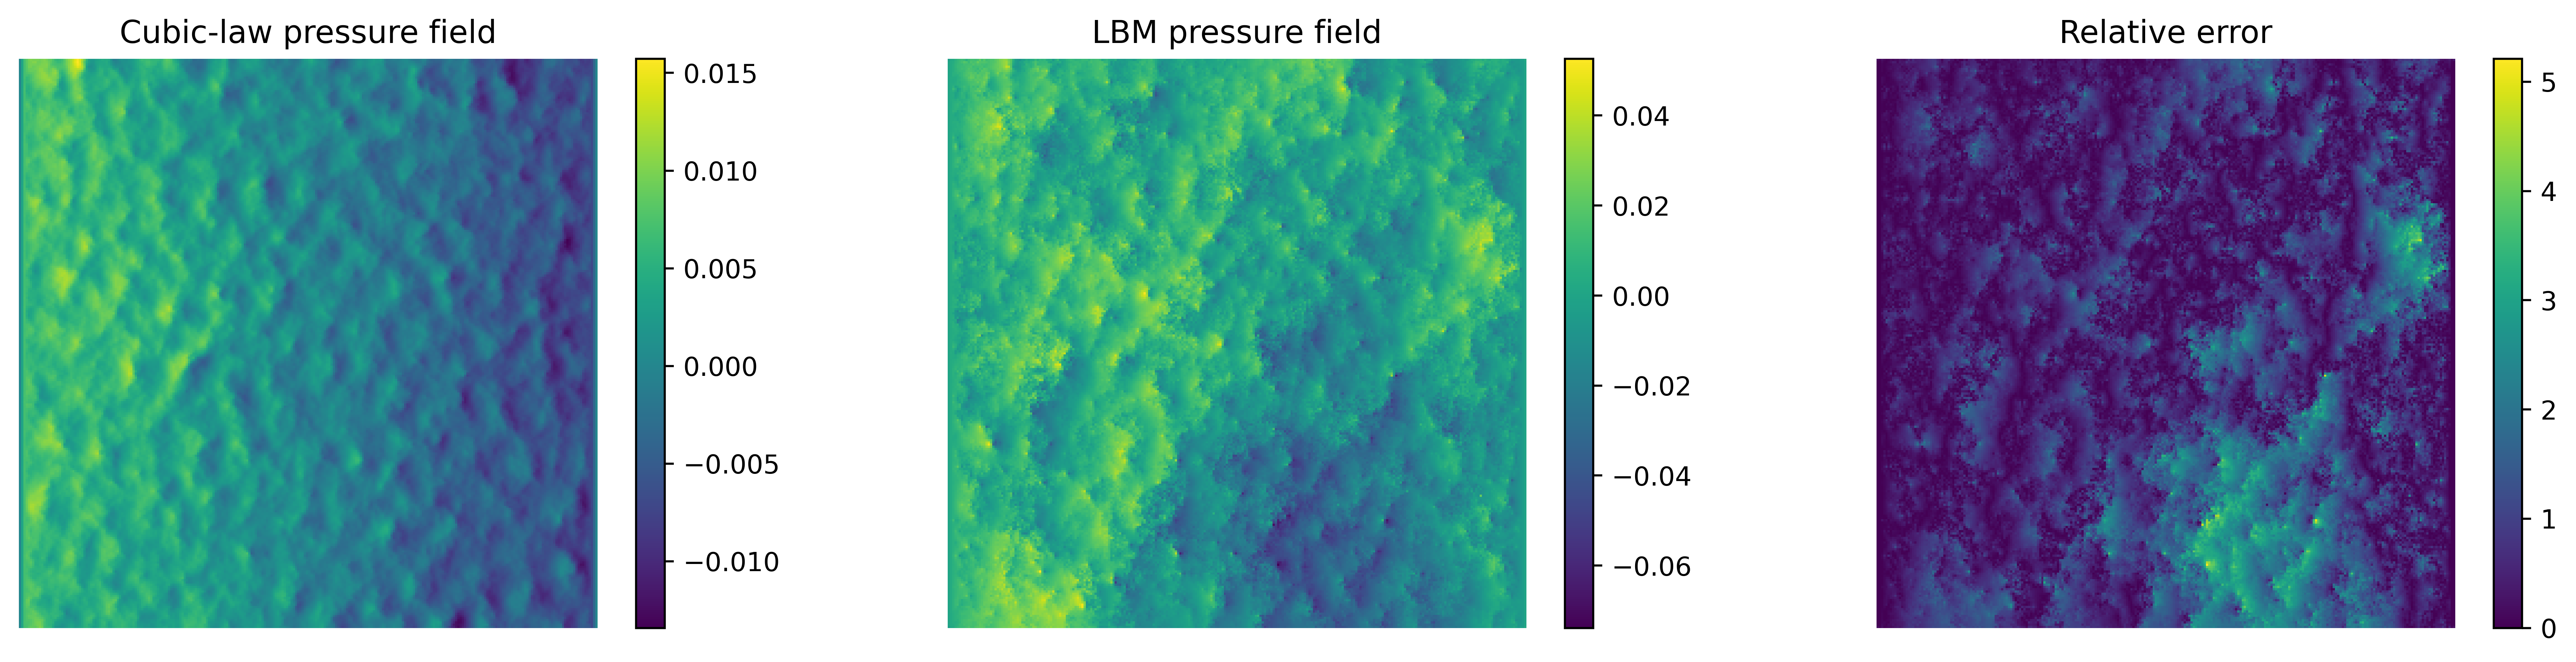

In [38]:
plt.figure(dpi=500, figsize=(9*2, 2*2));

plt.subplot(1,3,1)
plt.imshow((cubiclaw_pressure-linear_pressure)[0,0,]);plt.colorbar()
plt.title('Cubic-law pressure field')
plt.axis('off')
plt.subplot(1,3,2)
plt.imshow((pressure-linear_pressure)[0,0,]);plt.colorbar()
plt.title('LBM pressure field')
plt.axis('off')
plt.subplot(1,3,3)
plt.imshow(np.abs( (pressure-cubiclaw_pressure)*100/pressure)[0,0,]);plt.colorbar()
plt.title('Relative error')
plt.axis('off')

In [36]:
model.weights = torch.nn.Parameter(torch.ones(1, 1, *domain_size)*.5,requires_grad=True) # set the weights to .5
trainer = Trainer(max_epochs=100, log_every_n_steps=1)
trainer.fit(model, [aperture, pressure])

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name | Type | Params
------------------------------
------------------------------
66.6 K    Trainable params
0         Non-trainable params
66.6 K    Total params
0.266     Total estimated model params size (MB)


Epoch 43:   0%| | 0/1 [00:00<?, ?it/s, v_num=1, loss_step=9.14e-5, loss

/Users/jesantos/opt/anaconda3/envs/daily/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py:724: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


In [47]:
%load_ext tensorboard
%tensorboard --logdir lightning_logs

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [40]:
yhat = model(torch.as_tensor(aperture)) # prediction using the trained model
e = torch.abs( (yhat.detach()[0,0,]-pressure[0,0,])/yhat.detach()[0,0,] )*100

Text(0, 0.5, '[$\\mu m$]')

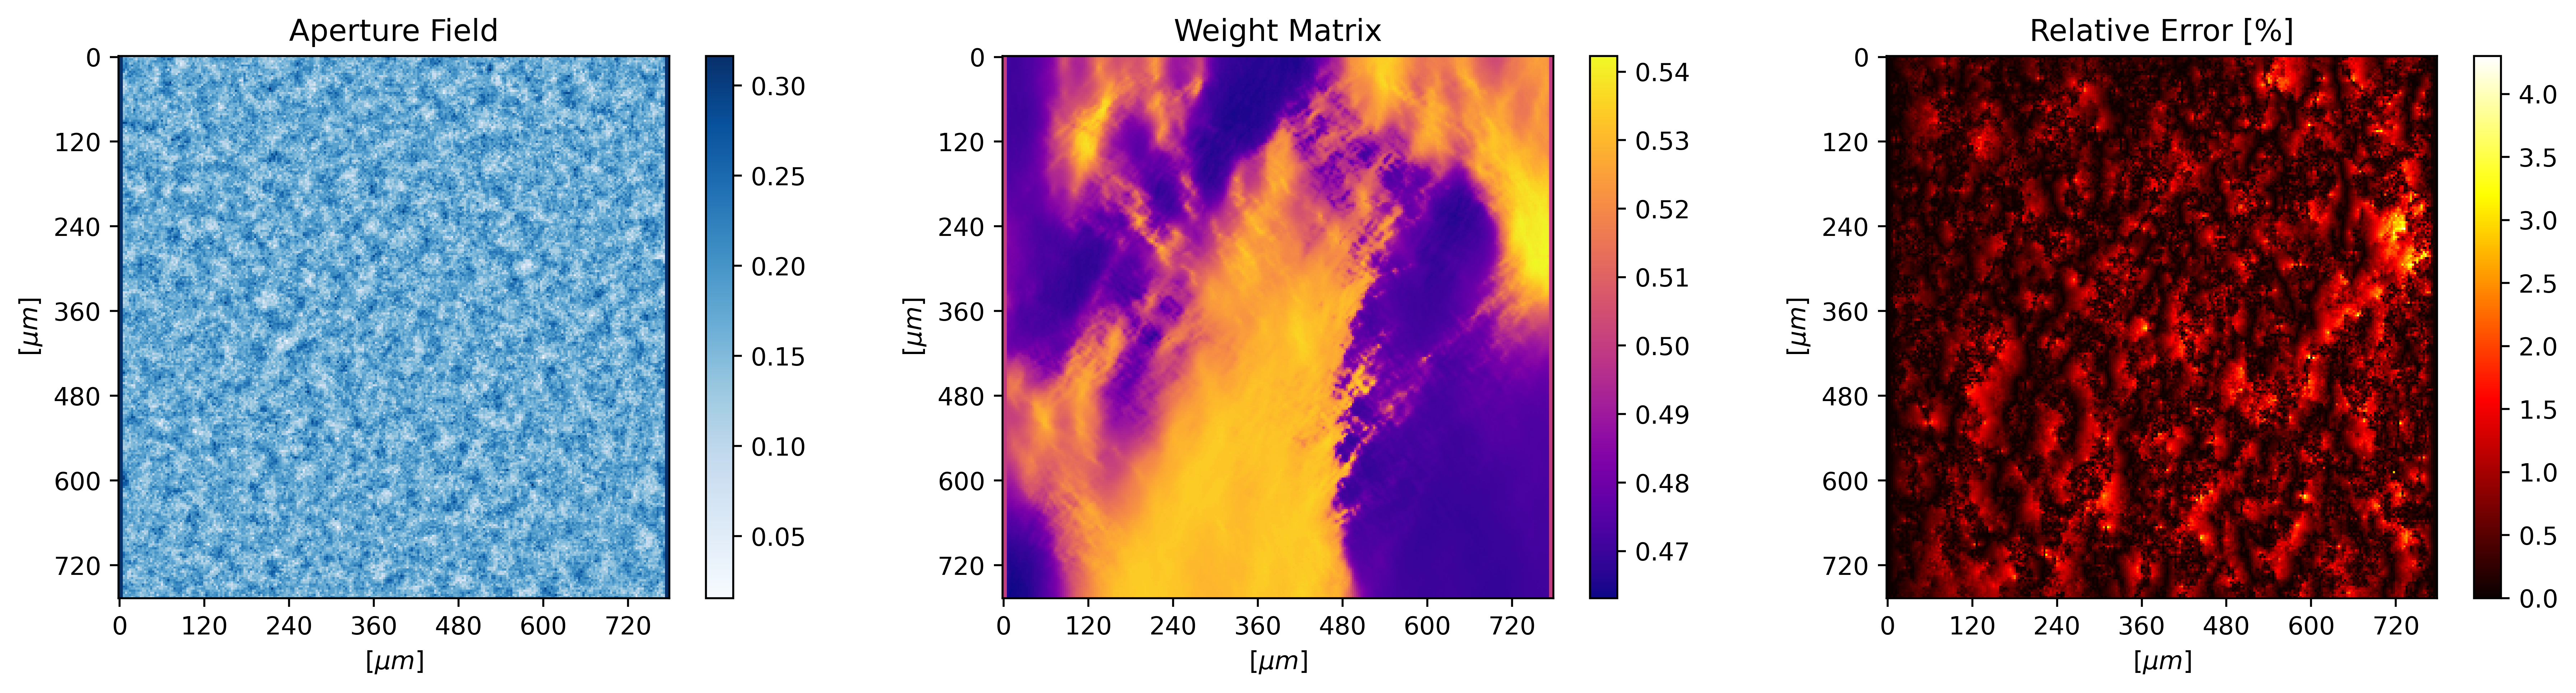

In [44]:
plt.figure(dpi=500, figsize=(9*2, 2*2));
plt.subplot(1,3,1)
plt.imshow(aperture[0,0,],cmap='Blues', vmax=0.31640625);plt.colorbar()
plt.title('Aperture Field')

x_positions = np.arange(0,250,40) # pixel count at label position
x_labels = x_positions*3

plt.xticks(x_positions, x_labels)
plt.xlabel('[$\mu m$]')
plt.yticks(x_positions, x_labels)
plt.ylabel('[$\mu m$]')

plt.subplot(1,3,2)
plt.imshow(model.weights.detach()[0,0,],cmap='plasma');plt.colorbar()
plt.title('Weight Matrix')

plt.xticks(x_positions, x_labels)
plt.xlabel('[$\mu m$]')
plt.yticks(x_positions, x_labels)
plt.ylabel('[$\mu m$]')


plt.subplot(1,3,3)
plt.imshow(e,cmap='hot');plt.colorbar()
plt.title('Relative Error [%]')

plt.xticks(x_positions, x_labels)
plt.xlabel('[$\mu m$]')
plt.yticks(x_positions, x_labels)
plt.ylabel('[$\mu m$]')